In [58]:
import numpy as np
import pickle
import csv
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import font_manager as fm, rcParams
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from cycler import cycler
from datetime import datetime
from tools import load, estimate_derivative

In [24]:
# path = r"/home/p308270/.local/share/fonts/Helvetica.ttf"  # or .otf
# path = r"/home/ton20/.local/share/fonts/Helvetica.ttf"  # or .otf

# fm.fontManager.addfont(path)
palette = ['#405cca', '#c23232', '#269f30', '#1d1d1d']
cmap = ListedColormap(palette, name='custom')
plt.rcParams.update({
    "font.size": 12,
    "font.family": "Helvetica",
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": False,
    "axes.prop_cycle": cycler(color=palette),

    "lines.linewidth": 1.5,     # default line width
    "axes.linewidth": 1.,      # axis spine width
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'xtick.minor.width': 1.0,
    'ytick.minor.width': 1.0,

    "hatch.linewidth": 1.,   # make hatch strokes visible

})
rng = np.random.default_rng(42)  # for reproducibility

In [59]:
file = '1_600_20'

sensor_data = []
times = []
with open(f'data/{file}.csv', 'r') as f:
    reader = csv.reader(f)
    # times = [row[0] for row in reader]
    for row in reader:
        if row[0] =='Timestamp':
            continue
        else:
            times.append(row[0])
            values = []
            for i in range(17):
                b1 = int(row[2*i+1])
                b2 = int(row[2*i+2])
                values.append(int.from_bytes([b1, b2], byteorder="little"))
            sensor_data.append(values)
sensor_data = np.array(sensor_data)
sequence = pickle.load(open(f'data/{file}_sequence.pkl', 'rb'))

d_sensor_data = np.apply_along_axis(estimate_derivative, axis=0, arr=sensor_data)

In [26]:
responding_sens = [0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
sensor_id = ["TGS2602", "TGS2610", "SP3S-AQ2", "GSBT11-DXX",
             "TGS2600", "TGS2603", "TGS2630", "TGS2612",
             "TGS2620", "MG-812", "TGS3830", "TGS1820",
             "TGS2611", "TGS2616", "WSP2110", "TGS-3870",
             "BME680"]

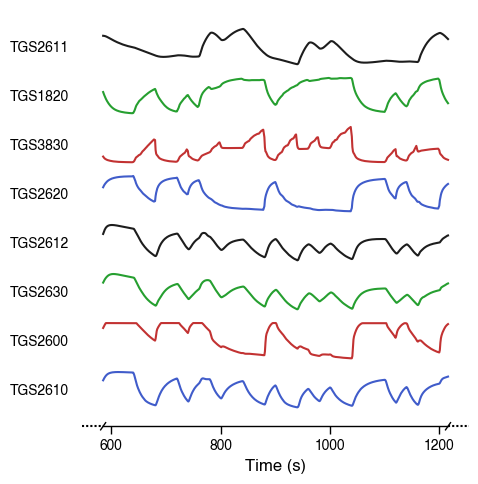

In [44]:
from datetime import datetime
import re
import numpy as np
import matplotlib.pyplot as plt

# --- provide these before running ---
idx_start, idx_end = 570, 1170  # example (inclusive)

# parse timestamps -> elapsed seconds since the FIRST label in `times`
t_dt = [datetime.strptime(t, "%Y-%m-%d %H:%M:%S.%f") for t in times]
t0 = t_dt[0]
t_secs = np.array([(t - t0).total_seconds() for t in t_dt], dtype=float)

# clamp & validate indices (inclusive interval)
idx_start = max(0, int(idx_start))
idx_end = min(len(t_secs) - 1, int(idx_end))
if idx_end <= idx_start:
    raise ValueError("idx_end must be greater than idx_start.")

sl = slice(idx_start, idx_end + 1)  # inclusive
t_sub = t_secs[sl]                  # <-- absolute seconds since first label (no rebasing)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# responding sensor indices and cleaned names
idxs = [i for i, v in enumerate(responding_sens) if v == 1]
names = [re.sub(r'^\s*UX\s*-\s*', '', sensor_id[i]) for i in idxs]

TARGET_HALF_HEIGHT = 0.9
EPS = 1e-12
BASELINE_LEN = 300  # use your original baseline length

for k, i in enumerate(idxs):
    row = sensor_data.T[i]

    # baseline from the first BASELINE_LEN samples of the full signal
    b_len = min(BASELINE_LEN, len(row))
    baseline = float(np.mean(row[:b_len]))
    signal = (row - baseline) / 65536.0

    # restrict to the selected index window
    s_sub = np.asarray(signal)[sl]

    # scale by min/max within the window to fit within ±TARGET_HALF_HEIGHT
    s_min, s_max = float(np.min(s_sub)), float(np.max(s_sub))
    s_mid = 0.5 * (s_max + s_min)
    p2p = max(s_max - s_min, EPS)
    s_scaled = (s_sub - s_mid) * (TARGET_HALF_HEIGHT / (0.5 * p2p))

    ax.plot(t_sub, 0.8*s_scaled + 2 * k)

# y labels and x limits
ax.set_yticks([2 * k for k in range(len(idxs))])
ax.set_yticklabels(names)
ax.set_xlabel("Time (s)")  # seconds since the first label in `times`
ax.set_xlim(t_secs[idx_start], t_secs[idx_end])  # absolute time window
ax.set_xticks([600,800,1000,1200])

# styling
ax.spines[["top", "right", "left"]].set_visible(False)
ax.tick_params(left=False, labelleft=True)
plt.tight_layout()
from matplotlib.lines import Line2D

# --- Axis decorations: dashed extensions + diagonal slashes ---
x0, x1 = t_secs[idx_start], t_secs[idx_end]
L = x1 - x0

# Show the dashed extensions: expand limits first
ext_frac = 0.06             # extend ~6% of window length on each side
ext = ext_frac * L
ax.set_xlim(x0 - ext, x1 + ext)

# Recompute span after expanding limits (for consistent 1% slash width)
xmin, xmax = ax.get_xlim()
span = xmax - xmin

# Slash size: w and h are both 0.01
slash_w = 0.015 * span       # 1% of current x-span, in data units
slash_h = 0.01              # 1% of axes height, in axes coords

# Match spine color
axis_color = ax.spines["bottom"].get_edgecolor()

# Mixed transform: x in data coords, y in axes coords (y=0 is the x-axis baseline)
xax = ax.get_xaxis_transform()

# 1) Dashed extensions (before and after)
for x_pair in [(x0 - ext, x0), (x1, x1 + ext)]:
    ax.add_line(Line2D(
        x_pair, [0, 0],
        transform=xax,
        linestyle=(0, (1., 1.)),   # short dashes
        # linestyle=':',   # short dashes
        linewidth=1.5,
        color=axis_color,
        solid_capstyle="butt",
        clip_on=False,
        zorder=3,
    ))
ax.spines["bottom"].set_bounds(x0, x1)  # spine only across the main window

# 2) Diagonal slashes exactly at the original window ends (x0, x1)
for xc in (x0, x1):
    ax.add_line(Line2D(
        [xc - 0.5 * slash_w, xc + 0.5 * slash_w],   # centered at the endpoint
        [-slash_h, slash_h],                        # symmetric about the axis line
        transform=xax,
        linewidth=1.,
        color=axis_color,
        solid_capstyle="butt",                      # helps the slash sit flush on the axis
        clip_on=False,
        zorder=4,
    ))

plt.savefig(f'figs/sensor_signal.png', dpi=300)
plt.savefig(f'figs/sensor_signal.pdf', dpi=300)
plt.show()


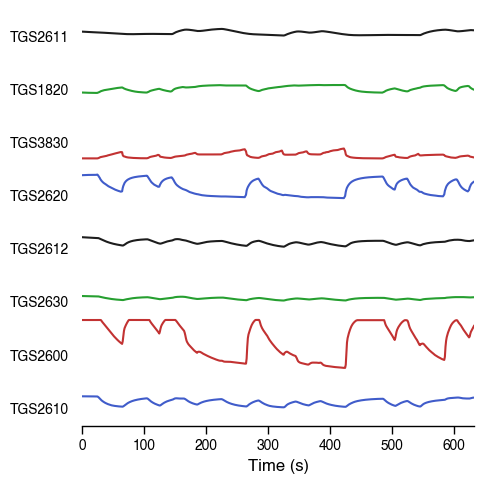

In [28]:
from datetime import datetime
import re
import numpy as np
import matplotlib.pyplot as plt

# --- set these before running ---
idx_start, idx_end = 600, 1200  # example (inclusive)

# parse timestamps -> elapsed seconds since first sample
t_dt = [datetime.strptime(t, "%Y-%m-%d %H:%M:%S.%f") for t in times]
t0 = t_dt[0]
t_secs = np.array([(t - t0).total_seconds() for t in t_dt], dtype=float)

# clamp & validate indices (inclusive interval)
idx_start = max(0, int(idx_start))
idx_end = min(len(t_secs) - 1, int(idx_end))
if idx_end <= idx_start:
    raise ValueError("idx_end must be greater than idx_start.")

sl = slice(idx_start, idx_end + 1)
t_sub = t_secs[sl] - t_secs[idx_start]  # rebase to 0 s within the window

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# responding sensor indices and cleaned names
idxs = [i for i, v in enumerate(responding_sens) if v == 1]
names = [re.sub(r'^\s*UX\s*-\s*', '', sensor_id[i]) for i in idxs]

BASELINE_LEN = 300  # same as before

for k, i in enumerate(idxs):
    row = sensor_data.T[i]

    # baseline-correct (first BASELINE_LEN samples of full series), then convert like your original code
    b_len = min(BASELINE_LEN, len(row))
    baseline = float(np.mean(row[:b_len]))
    signal = (row - baseline) / 65536.0

    # take the selected window (no further scaling), just offset for readability
    s_sub = np.asarray(signal)[sl]
    ax.plot(t_sub, 6*s_sub + 2 * k)

# y labels and x limits
ax.set_yticks([2 * k for k in range(len(idxs))])
ax.set_yticklabels(names)
ax.set_xlabel("Time (s)")
ax.set_xlim(0, t_sub[-1])

# styling
ax.spines[["top", "right", "left"]].set_visible(False)
ax.tick_params(left=False, labelleft=True)
plt.tight_layout()


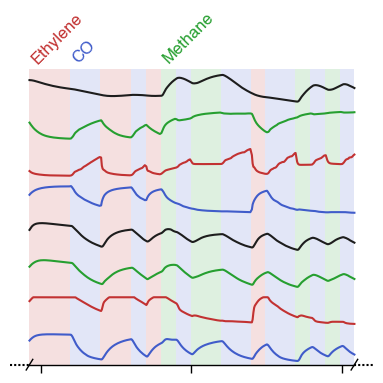

In [62]:
from datetime import datetime
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# ----------------------------
# Load your data
# ----------------------------
filename = '1_600_20'
# expects: times_sec (per-sample seconds), sequence_sec (change times for sequence)
# plus (in scope): sensor_data, responding_sens, sensor_id, sequence
_, _, times_sec, sequence_sec = load(filename, reduced=True)
# Rebase to seconds since the first value in sensor_data
t0 = float(times_sec[0])
t_secs0 = times_sec - t0


# ----------------------------
# Window selection (inclusive indices)
# ----------------------------
idx_start, idx_end = 570, 980
idx_start = max(0, int(idx_start))
idx_end = min(len(times_sec) - 1, int(idx_end))
if idx_end <= idx_start:
    raise ValueError("idx_end must be greater than idx_start.")
# sl = slice(idx_start, idx_end + 1)
# t_sub = times_sec[sl]
sl = slice(idx_start, idx_end + 1)
t_sub = t_secs0[sl]   # <- was times_sec[sl]

# ----------------------------
# Figure / axes
# ----------------------------

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

# ----------------------------
# Trace placement constants
# ----------------------------
idxs = [i for i, v in enumerate(responding_sens) if v == 1]
names = [re.sub(r'^\s*UX\s*-\s*', '', sensor_id[i]) for i in idxs]

TARGET_HALF_HEIGHT = 0.9
TRACE_SCALE        = 0.8
AMP                = TRACE_SCALE * TARGET_HALF_HEIGHT  # ~0.72

if len(idxs) > 0:
    bottom_of_lowest = -AMP
    top_of_highest   = 2 * (len(idxs) - 1) + AMP
else:
    bottom_of_lowest = 0.0
    top_of_highest   = 1.0

LABEL_HEADROOM = -0.2
y_label_data   = top_of_highest + 0.5
ymin_fixed     = bottom_of_lowest - 0.20
ymax_fixed     = y_label_data + LABEL_HEADROOM

ax.set_ylim(ymin_fixed, ymax_fixed)
ax.set_autoscale_on(False)

# ----------------------------
# Background gas rectangles  (axvspan -> x=data, y=axes)
# ----------------------------
max_len_blocks = 20
rect_alpha     = 0.15

gas_names = {1: "CO", 2: "Ethylene", 3: "Methane"}
def _gas_label(lab: int) -> str:
    return gas_names.get(int(lab), f"Gas {int(lab)}")

# per-sample gas labels over full recording
colour_full = np.zeros_like(times_sec, dtype=int)
for i in range(len(sequence_sec)):
    t_start = sequence_sec[i]
    t_end   = sequence_sec[i + 1] if i + 1 < len(sequence_sec) else np.inf
    mask = (times_sec >= t_start) & (times_sec < t_end)
    colour_full[mask] = int(sequence[i][1])  # adjust if your sequence structure differs

labels_local = colour_full[sl]
x_window     = t_sub

def _find_blocks(labels, max_len=20, ignore=0):
    labels = np.asarray(labels)
    n = len(labels)
    if n == 0: return []
    blocks, start, prev = [], 0, labels[0]
    for i in range(1, n + 1):
        cur = labels[i] if i < n else None
        if cur != prev:
            if prev != ignore:
                run_start, run_end, lab = start, i, int(prev)
                s = run_start
                while s < run_end:
                    e = min(s + max_len, run_end)
                    blocks.append((s, e, lab))  # [s,e)
                    s = e
            start, prev = i, cur
    return blocks

def _block_edges_from_indices(x, s, e):
    if s <= 0:
        L = x[0]
    else:
        L = 0.5 * (x[s - 1] + x[s])
    if e >= len(x):
        R = x[-1]
    else:
        R = 0.5 * (x[e - 1] + x[e])
    return L, R

blocks = _find_blocks(labels_local, max_len=max_len_blocks, ignore=0)

# Draw each band with axvspan (works with blended transform internally)
for s, e, lab in blocks:
    if lab == 0:
        continue
    L, R = _block_edges_from_indices(x_window, s, e)
    if R <= L:
        continue
    ax.axvspan(
        L, R, ymin=0.0, ymax=1.0,
        facecolor=cmap((int(lab) - 1) % cmap.N),
        alpha=rect_alpha, linewidth=0, zorder=0
    )

# ----------------------------
# Traces
# ----------------------------
EPS = 1e-12
BASELINE_LEN = 300
for k, i in enumerate(idxs):
    row = sensor_data.T[i]
    b_len = min(BASELINE_LEN, len(row))
    baseline = float(np.mean(row[:b_len]))
    signal = (row - baseline) / 65536.0
    s_sub = np.asarray(signal)[sl]

    s_min, s_max = float(np.min(s_sub)), float(np.max(s_sub))
    s_mid = 0.5 * (s_max + s_min)
    p2p  = max(s_max - s_min, EPS)
    s_scaled = (s_sub - s_mid) * (TARGET_HALF_HEIGHT / (0.5 * p2p))

    ax.plot(t_sub, TRACE_SCALE * s_scaled + 2 * k, zorder=2,
            # c=cmap(3),
            )

# ----------------------------
# Gas labels (data coords)
# ----------------------------
seen_for_label = set()
x_text_offset = -0.5
for s, e, lab in blocks:
    if lab == 0 or lab in seen_for_label:
        continue
    L, R = _block_edges_from_indices(x_window, s, e)
    if R <= L:
        continue
    seen_for_label.add(lab)
    x_mid = 0.5 * (L + R)
    x_lbl = x_mid + x_text_offset * (R - L)
    ax.text(
        x_lbl, y_label_data, _gas_label(lab),
        transform=ax.transData, ha='left', va='bottom',
        rotation=45,
        color=cmap((int(lab) - 1) % cmap.N),
        clip_on=False, zorder=5
    )

# ----------------------------
# Axes labels and limits (x)
# ----------------------------
# ax.set_yticks([2 * k for k in range(len(idxs))])
# ax.set_yticklabels(names)
ax.set_yticks([])
# ax.set_xlabel("Time (s)")
ax.set_xlim(times_sec[idx_start], times_sec[idx_end])
ax.set_xticks([600, 800, 1000, 1200], labels = [])
# ax.text(-0.1, 0.5, '$S(t)$', transform=ax.transAxes)

# styling
ax.spines[["top", "right", "left"]].set_visible(False)
ax.tick_params(left=False, labelleft=True)
plt.tight_layout()

# ----------------------------
# Axis decorations (x-axis only)
# ----------------------------
# x0, x1 = times_sec[idx_start], times_sec[idx_end]
x0, x1 = t_secs0[idx_start], t_secs0[idx_end]
Lx = x1 - x0
ext_frac = 0.06
ext = ext_frac * Lx
ax.set_xlim(x0 - ext, x1 + ext)

xmin, xmax = ax.get_xlim()
span = xmax - xmin
slash_w = 0.02 * span
slash_h = 0.02
axis_color = ax.spines["bottom"].get_edgecolor()
xax = ax.get_xaxis_transform()

for x_pair in [(x0 - ext, x0), (x1, x1 + ext)]:
    ax.add_line(Line2D(
        x_pair, [0, 0], transform=xax,
        linestyle=(0, (1., 1.)), linewidth=1.5,
        color=axis_color, solid_capstyle="butt",
        clip_on=False, zorder=3,
    ))
ax.spines["bottom"].set_bounds(x0, x1)
for xc in (x0, x1):
    ax.add_line(Line2D(
        [xc - 0.5 * slash_w, xc + 0.5 * slash_w],
        [-slash_h, slash_h],
        transform=xax, linewidth=1., color=axis_color,
        solid_capstyle="butt", clip_on=False, zorder=4,
    ))

# ----------------------------
# Save & show
# ----------------------------
plt.savefig('figs/signal_1.png', dpi=300)
plt.savefig('figs/signal_1.pdf', dpi=300)
plt.show()


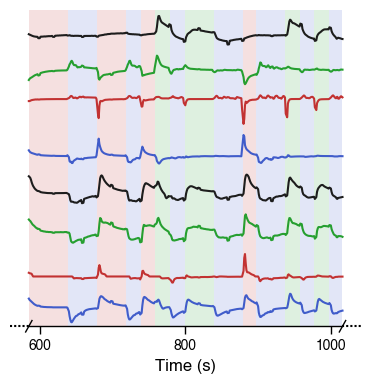

In [66]:
# ----------------------------
# Load your data
# ----------------------------
filename = '1_600_20'
# expects: times_sec (per-sample seconds), sequence_sec (change times for sequence)
# plus (in scope): sensor_data, responding_sens, sensor_id, sequence
_, _, times_sec, sequence_sec = load(filename, reduced=True)
# Rebase to seconds since the first value in sensor_data
t0 = float(times_sec[0])
t_secs0 = times_sec - t0


# ----------------------------
# Window selection (inclusive indices)
# ----------------------------
idx_start, idx_end = 570, 980
idx_start = max(0, int(idx_start))
idx_end = min(len(times_sec) - 1, int(idx_end))
if idx_end <= idx_start:
    raise ValueError("idx_end must be greater than idx_start.")
# sl = slice(idx_start, idx_end + 1)
# t_sub = times_sec[sl]
sl = slice(idx_start, idx_end + 1)
t_sub = t_secs0[sl]   # <- was times_sec[sl]

# ----------------------------
# Figure / axes
# ----------------------------

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

# ----------------------------
# Trace placement constants
# ----------------------------
idxs = [i for i, v in enumerate(responding_sens) if v == 1]
names = [re.sub(r'^\s*UX\s*-\s*', '', sensor_id[i]) for i in idxs]

TARGET_HALF_HEIGHT = 0.9
TRACE_SCALE        = 0.8
AMP                = TRACE_SCALE * TARGET_HALF_HEIGHT  # ~0.72

if len(idxs) > 0:
    bottom_of_lowest = -AMP
    top_of_highest   = 2 * (len(idxs) - 1) + AMP
else:
    bottom_of_lowest = 0.0
    top_of_highest   = 1.0

LABEL_HEADROOM = -0.2
y_label_data   = top_of_highest + 0.5
ymin_fixed     = bottom_of_lowest - 0.20
ymax_fixed     = y_label_data + LABEL_HEADROOM

ax.set_ylim(ymin_fixed, ymax_fixed)
ax.set_autoscale_on(False)

# ----------------------------
# Background gas rectangles  (axvspan -> x=data, y=axes)
# ----------------------------
max_len_blocks = 20
rect_alpha     = 0.15

gas_names = {1: "CO", 2: "Ethylene", 3: "Methane"}
def _gas_label(lab: int) -> str:
    return gas_names.get(int(lab), f"Gas {int(lab)}")

# per-sample gas labels over full recording
colour_full = np.zeros_like(times_sec, dtype=int)
for i in range(len(sequence_sec)):
    t_start = sequence_sec[i]
    t_end   = sequence_sec[i + 1] if i + 1 < len(sequence_sec) else np.inf
    mask = (times_sec >= t_start) & (times_sec < t_end)
    colour_full[mask] = int(sequence[i][1])  # adjust if your sequence structure differs

labels_local = colour_full[sl]
x_window     = t_sub

def _find_blocks(labels, max_len=20, ignore=0):
    labels = np.asarray(labels)
    n = len(labels)
    if n == 0: return []
    blocks, start, prev = [], 0, labels[0]
    for i in range(1, n + 1):
        cur = labels[i] if i < n else None
        if cur != prev:
            if prev != ignore:
                run_start, run_end, lab = start, i, int(prev)
                s = run_start
                while s < run_end:
                    e = min(s + max_len, run_end)
                    blocks.append((s, e, lab))  # [s,e)
                    s = e
            start, prev = i, cur
    return blocks

def _block_edges_from_indices(x, s, e):
    if s <= 0:
        L = x[0]
    else:
        L = 0.5 * (x[s - 1] + x[s])
    if e >= len(x):
        R = x[-1]
    else:
        R = 0.5 * (x[e - 1] + x[e])
    return L, R

blocks = _find_blocks(labels_local, max_len=max_len_blocks, ignore=0)

# Draw each band with axvspan (works with blended transform internally)
for s, e, lab in blocks:
    if lab == 0:
        continue
    L, R = _block_edges_from_indices(x_window, s, e)
    if R <= L:
        continue
    ax.axvspan(
        L, R, ymin=0.0, ymax=1.0,
        facecolor=cmap((int(lab) - 1) % cmap.N),
        alpha=rect_alpha, linewidth=0, zorder=0
    )

# ----------------------------
# Traces
# ----------------------------
EPS = 1e-12
BASELINE_LEN = 300
for k, i in enumerate(idxs):
    row = d_sensor_data.T[i]
    b_len = min(BASELINE_LEN, len(row))
    baseline = float(np.mean(row[:b_len]))
    signal = (row - baseline) / 65536.0
    s_sub = np.asarray(signal)[sl]

    s_min, s_max = float(np.min(s_sub)), float(np.max(s_sub))
    s_mid = 0.5 * (s_max + s_min)
    p2p  = max(s_max - s_min, EPS)
    s_scaled = (s_sub - s_mid) * (TARGET_HALF_HEIGHT / (0.5 * p2p))

    ax.plot(t_sub, TRACE_SCALE * s_scaled + 2 * k, zorder=2,
            # c=cmap(3),
            )

# ----------------------------
# Gas labels (data coords)
# ----------------------------
seen_for_label = set()
x_text_offset = -0.5
for s, e, lab in blocks:
    if lab == 0 or lab in seen_for_label:
        continue
    L, R = _block_edges_from_indices(x_window, s, e)
    if R <= L:
        continue
    seen_for_label.add(lab)
    x_mid = 0.5 * (L + R)
    x_lbl = x_mid + x_text_offset * (R - L)
    # ax.text(
    #     x_lbl, y_label_data, _gas_label(lab),
    #     transform=ax.transData, ha='left', va='bottom',
    #     rotation=45,
    #     color=cmap((int(lab) - 1) % cmap.N),
    #     clip_on=False, zorder=5
    # )

# ----------------------------
# Axes labels and limits (x)
# ----------------------------
# ax.set_yticks([2 * k for k in range(len(idxs))])
# ax.set_yticklabels(names)
ax.set_yticks([])
ax.set_xlabel("Time (s)")
ax.set_xlim(times_sec[idx_start], times_sec[idx_end])
ax.set_xticks([600, 800, 1000, 1200])
# ax.text(-0.1, 0.5, '$S(t)$', transform=ax.transAxes)

# styling
ax.spines[["top", "right", "left"]].set_visible(False)
ax.tick_params(left=False, labelleft=True)
plt.tight_layout()

# ----------------------------
# Axis decorations (x-axis only)
# ----------------------------
# x0, x1 = times_sec[idx_start], times_sec[idx_end]
x0, x1 = t_secs0[idx_start], t_secs0[idx_end]
Lx = x1 - x0
ext_frac = 0.06
ext = ext_frac * Lx
ax.set_xlim(x0 - ext, x1 + ext)

xmin, xmax = ax.get_xlim()
span = xmax - xmin
slash_w = 0.02 * span
slash_h = 0.02
axis_color = ax.spines["bottom"].get_edgecolor()
xax = ax.get_xaxis_transform()

for x_pair in [(x0 - ext, x0), (x1, x1 + ext)]:
    ax.add_line(Line2D(
        x_pair, [0, 0], transform=xax,
        linestyle=(0, (1., 1.)), linewidth=1.5,
        color=axis_color, solid_capstyle="butt",
        clip_on=False, zorder=3,
    ))
ax.spines["bottom"].set_bounds(x0, x1)
for xc in (x0, x1):
    ax.add_line(Line2D(
        [xc - 0.5 * slash_w, xc + 0.5 * slash_w],
        [-slash_h, slash_h],
        transform=xax, linewidth=1., color=axis_color,
        solid_capstyle="butt", clip_on=False, zorder=4,
    ))

# ----------------------------
# Save & show
# ----------------------------
plt.savefig('figs/signal_2.png', dpi=300)
plt.savefig('figs/signal_2.pdf', dpi=300)
plt.show()

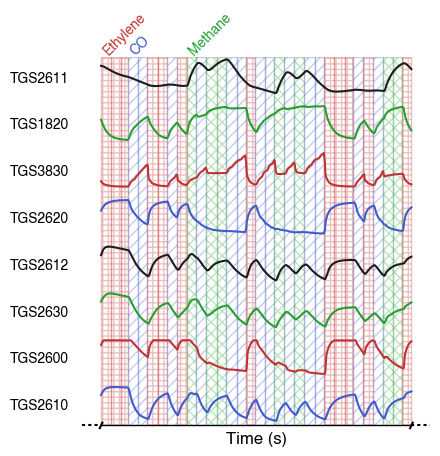

In [30]:
from datetime import datetime
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ----------------------------
# Load your data
# ----------------------------
filename = '1_600_20'
# expects: times_sec (per-sample seconds), sequence_sec (change times for sequence)
# plus (in scope): sensor_data, responding_sens, sensor_id, sequence
_, _, times_sec, sequence_sec = load(filename, reduced=True)

# ----------------------------
# Window selection (inclusive indices)
# ----------------------------
idx_start, idx_end = 570, 1170
idx_start = max(0, int(idx_start))
idx_end = min(len(times_sec) - 1, int(idx_end))
if idx_end <= idx_start:
    raise ValueError("idx_end must be greater than idx_start.")
sl = slice(idx_start, idx_end + 1)
t_sub = times_sec[sl]

# ----------------------------
# Figure / axes
# ----------------------------

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# ----------------------------
# Trace placement constants
# ----------------------------
idxs = [i for i, v in enumerate(responding_sens) if v == 1]
names = [re.sub(r'^\s*UX\s*-\s*', '', sensor_id[i]) for i in idxs]

TARGET_HALF_HEIGHT = 0.9
TRACE_SCALE        = 0.8
AMP                = TRACE_SCALE * TARGET_HALF_HEIGHT  # ~0.72

if len(idxs) > 0:
    bottom_of_lowest = -AMP
    top_of_highest   = 2 * (len(idxs) - 1) + AMP
else:
    bottom_of_lowest = 0.0
    top_of_highest   = 1.0

LABEL_HEADROOM = 0.0
y_label_data   = top_of_highest + 0.10
ymin_fixed     = bottom_of_lowest - 0.20
ymax_fixed     = y_label_data + LABEL_HEADROOM

ax.set_ylim(ymin_fixed, ymax_fixed)
ax.set_autoscale_on(False)

# ----------------------------
# Background gas bands (textured/hatched)
# ----------------------------
max_len_blocks = 20
rect_face      = "white"   # keep fill white
band_z         = 1         # above axes facecolor, below lines

gas_names = {1: "CO", 2: "Ethylene", 3: "Methane"}
def _gas_label(lab: int) -> str:
    return gas_names.get(int(lab), f"Gas {int(lab)}")

# Assign a distinct hatch per gas id
# HATCHES = ['///', '\\\\\\', 'xxx', '+++', '---', '|||', 'ooo', '***', '...','OO']
HATCHES = ['///', "+++", 'xxx']

def hatch_for(lab: int) -> str:
    return HATCHES[(int(lab) - 1) % len(HATCHES)]

# per-sample gas labels over full recording
colour_full = np.zeros_like(times_sec, dtype=int)
for i in range(len(sequence_sec)):
    t_start = sequence_sec[i]
    t_end   = sequence_sec[i + 1] if i + 1 < len(sequence_sec) else np.inf
    mask = (times_sec >= t_start) & (times_sec < t_end)
    colour_full[mask] = int(sequence[i][1])  # adjust if your sequence structure differs

labels_local = colour_full[sl]
x_window     = t_sub

def _find_blocks(labels, max_len=20, ignore=0):
    labels = np.asarray(labels)
    n = len(labels)
    if n == 0: return []
    blocks, start, prev = [], 0, labels[0]
    for i in range(1, n + 1):
        cur = labels[i] if i < n else None
        if cur != prev:
            if prev != ignore:
                run_start, run_end, lab = start, i, int(prev)
                s = run_start
                while s < run_end:
                    e = min(s + max_len, run_end)
                    blocks.append((s, e, lab))  # [s,e)
                    s = e
            start, prev = i, cur
    return blocks

def _block_edges_from_indices(x, s, e):
    if s <= 0:
        L = x[0]
    else:
        L = 0.5 * (x[s - 1] + x[s])
    if e >= len(x):
        R = x[-1]
    else:
        R = 0.5 * (x[e - 1] + x[e])
    return L, R

blocks = _find_blocks(labels_local, max_len=max_len_blocks, ignore=0)

# Draw each band with hatch (axvspan supports hatching; hatch color = edgecolor)
for s, e, lab in blocks:
    if lab == 0:
        continue
    L, R = _block_edges_from_indices(x_window, s, e)
    if R <= L:
        continue
    edge_col = cmap((int(lab) - 1) % cmap.N)
    ax.axvspan(
        L, R, ymin=0.0, ymax=1.0,
        facecolor=rect_face,       # white fill
        edgecolor=edge_col,        # hatch color
        hatch=hatch_for(lab),
        linewidth=1.,             # border off; hatch linewidth is controlled by rcParam
        zorder=band_z,
        alpha=0.3
    )

# ----------------------------
# Traces
# ----------------------------
EPS = 1e-12
BASELINE_LEN = 300
for k, i in enumerate(idxs):
    row = sensor_data.T[i]
    b_len = min(BASELINE_LEN, len(row))
    baseline = float(np.mean(row[:b_len]))
    signal = (row - baseline) / 65536.0
    s_sub = np.asarray(signal)[sl]

    s_min, s_max = float(np.min(s_sub)), float(np.max(s_sub))
    s_mid = 0.5 * (s_max + s_min)
    p2p  = max(s_max - s_min, EPS)
    s_scaled = (s_sub - s_mid) * (TARGET_HALF_HEIGHT / (0.5 * p2p))

    ax.plot(t_sub, TRACE_SCALE * s_scaled + 2 * k, zorder=2)

# ----------------------------
# Gas labels (data coords)
# ----------------------------
seen_for_label = set()
x_text_offset = -0.5
for s, e, lab in blocks:
    if lab == 0 or lab in seen_for_label:
        continue
    L, R = _block_edges_from_indices(x_window, s, e)
    if R <= L:
        continue
    seen_for_label.add(lab)
    x_mid = 0.5 * (L + R)
    x_lbl = x_mid + x_text_offset * (R - L)
    ax.text(
        x_lbl, y_label_data, _gas_label(lab),
        transform=ax.transData, ha='left', va='bottom',
        rotation=45,
        color=cmap((int(lab) - 1) % cmap.N),
        fontsize=10,
        clip_on=False, zorder=5
    )

# ----------------------------
# Axes labels and limits (x)
# ----------------------------
ax.set_yticks([2 * k for k in range(len(idxs))])
ax.set_yticklabels(names)
ax.set_xlabel("Time (s)")
ax.set_xlim(times_sec[idx_start], times_sec[idx_end])
ax.set_xticks([600, 800, 1000, 1200])

# styling
ax.spines[["top", "right", "left"]].set_visible(False)
ax.tick_params(left=False, labelleft=True)
plt.tight_layout()

# ----------------------------
# Axis decorations (x-axis only)
# ----------------------------
x0, x1 = times_sec[idx_start], times_sec[idx_end]
Lx = x1 - x0
ext_frac = 0.06
ext = ext_frac * Lx
ax.set_xlim(x0 - ext, x1 + ext)

xmin, xmax = ax.get_xlim()
span = xmax - xmin
slash_w = 0.01 * span
slash_h = 0.01
axis_color = ax.spines["bottom"].get_edgecolor()
xax = ax.get_xaxis_transform()

for x_pair in [(x0 - ext, x0), (x1, x1 + ext)]:
    ax.add_line(Line2D(
        x_pair, [0, 0], transform=xax,
        linestyle=(0, (1.5, 1.5)), linewidth=1.5,
        color=axis_color, solid_capstyle="butt",
        clip_on=False, zorder=3,
    ))
ax.spines["bottom"].set_bounds(x0, x1)
for xc in (x0, x1):
    ax.add_line(Line2D(
        [xc - 0.5 * slash_w, xc + 0.5 * slash_w],
        [-slash_h, slash_h],
        transform=xax, linewidth=1.5, color=axis_color,
        solid_capstyle="butt", clip_on=False, zorder=4,
    ))

# ----------------------------
# Save & show
# ----------------------------
plt.savefig('figs/sensor_signal_textured.png', dpi=300)
plt.savefig('figs/sensor_signal_textured.pdf', dpi=300)
plt.show()


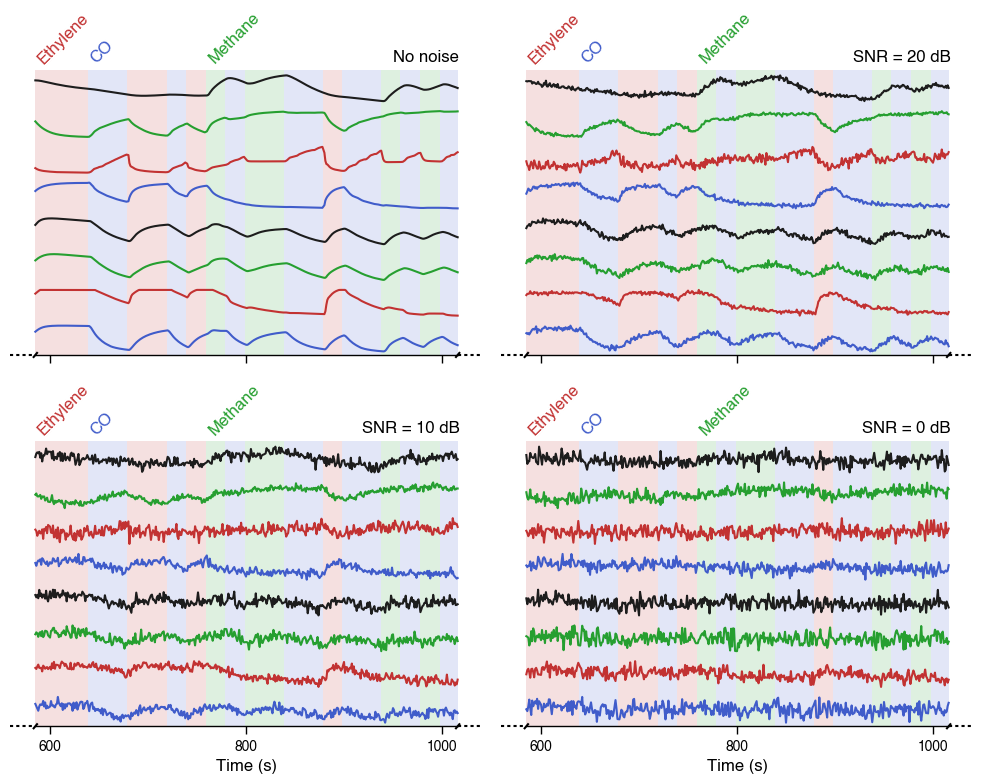

In [31]:
from datetime import datetime
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# ----------------------------
# Load your data
# ----------------------------
filename = '1_600_20'
# expects: times_sec (per-sample seconds), sequence_sec (change times for sequence)
# plus (in scope): sensor_data, responding_sens, sensor_id, sequence
_, _, times_sec, sequence_sec = load(filename, reduced=True)
# Rebase to seconds since the first value in sensor_data
t0 = float(times_sec[0])
t_secs0 = times_sec - t0

# ----------------------------
# Window selection (inclusive indices)
# ----------------------------
idx_start, idx_end = 570, 980
idx_start = max(0, int(idx_start))
idx_end = min(len(times_sec) - 1, int(idx_end))
if idx_end <= idx_start:
    raise ValueError("idx_end must be greater than idx_start.")
sl = slice(idx_start, idx_end + 1)
t_sub = t_secs0[sl]   # windowed time in seconds since start

# ----------------------------
# Trace placement constants
# ----------------------------
idxs = [i for i, v in enumerate(responding_sens) if v == 1]
names = [re.sub(r'^\s*UX\s*-\s*', '', sensor_id[i]) for i in idxs]

TARGET_HALF_HEIGHT = 0.9
TRACE_SCALE        = 0.8
AMP                = TRACE_SCALE * TARGET_HALF_HEIGHT  # ~0.72
EPS                = 1e-12
BASELINE_LEN       = 300

if len(idxs) > 0:
    bottom_of_lowest = -AMP
    top_of_highest   = 2 * (len(idxs) - 1) + AMP
else:
    bottom_of_lowest = 0.0
    top_of_highest   = 1.0

LABEL_HEADROOM = -0.2
y_label_data   = top_of_highest + 0.5
ymin_fixed     = bottom_of_lowest - 0.20
ymax_fixed     = y_label_data + LABEL_HEADROOM

# ----------------------------
# Background gas rectangles
# ----------------------------
max_len_blocks = 20
rect_alpha     = 0.15

gas_names = {1: "CO", 2: "Ethylene", 3: "Methane"}
def _gas_label(lab: int) -> str:
    return gas_names.get(int(lab), f"Gas {int(lab)}")

# per-sample gas labels over full recording
colour_full = np.zeros_like(times_sec, dtype=int)
for i in range(len(sequence_sec)):
    t_start = sequence_sec[i]
    t_end   = sequence_sec[i + 1] if i + 1 < len(sequence_sec) else np.inf
    mask = (times_sec >= t_start) & (times_sec < t_end)
    colour_full[mask] = int(sequence[i][1])  # adjust if your sequence structure differs

labels_local = colour_full[sl]
x_window     = t_sub

def _find_blocks(labels, max_len=20, ignore=0):
    labels = np.asarray(labels)
    n = len(labels)
    if n == 0: return []
    blocks, start, prev = [], 0, labels[0]
    for i in range(1, n + 1):
        cur = labels[i] if i < n else None
        if cur != prev:
            if prev != ignore:
                run_start, run_end, lab = start, i, int(prev)
                s = run_start
                while s < run_end:
                    e = min(s + max_len, run_end)
                    blocks.append((s, e, lab))  # [s,e)
                    s = e
            start, prev = i, cur
    return blocks

def _block_edges_from_indices(x, s, e):
    if s <= 0:
        L = x[0]
    else:
        L = 0.5 * (x[s - 1] + x[s])
    if e >= len(x):
        R = x[-1]
    else:
        R = 0.5 * (x[e - 1] + x[e])
    return L, R

blocks = _find_blocks(labels_local, max_len=max_len_blocks, ignore=0)

# ----------------------------
# Helper: assemble windowed traces (columns = sensors shown)
# ----------------------------
def get_windowed_traces_matrix():
    cols = []
    for i in idxs:
        # sensor_data is (N, 8); sensor_data.T[i] selects column i (length N)
        row = sensor_data.T[i]
        b_len = min(BASELINE_LEN, len(row))
        baseline = float(np.mean(row[:b_len]))
        signal = (row - baseline) / 65536.0
        s_sub = np.asarray(signal)[sl]
        cols.append(s_sub)
    if not cols:
        return np.zeros((len(t_sub), 0))
    return np.stack(cols, axis=1)  # shape: (len(t_sub), M)

S_clean = get_windowed_traces_matrix()  # (T, M)

# ----------------------------
# Noise adder for (N, M) with per-column SNR
# ----------------------------
def add_white_noise_cols(X, snr_db=None, snr_linear=None, seed=None, eps=1e-12):
    X = np.asarray(X, dtype=float)
    if X.ndim != 2:
        raise ValueError("X must be 2D, shape (N, M).")
    if (snr_db is None) == (snr_linear is None):
        raise ValueError("Provide exactly one of snr_db or snr_linear.")
    if snr_linear is None:
        snr_linear = 10.0 ** (snr_db / 10.0)
    sig_power = np.mean(X**2, axis=0, keepdims=True)  # (1, M)
    noise_power = sig_power / (snr_linear + eps)
    noise_std = np.sqrt(np.maximum(noise_power, 0.0))  # (1, M)
    rng = np.random.default_rng(seed)
    noise = rng.normal(0.0, 1.0, size=X.shape) * noise_std
    return X + noise

# --- Add this helper somewhere above plot_panel ---
from matplotlib.lines import Line2D

def decorate_x_axis_with_slashes(ax, x0, x1, ext_frac=0.06):
    """Draw dashed extensions and diagonal slashes at the x-axis window edges."""
    # Use the same extension you used for xlim
    Lx = x1 - x0
    ext = ext_frac * Lx

    # Make sure limits match (they should already)
    ax.set_xlim(x0 - ext, x1 + ext)

    # Axis transform for drawing along the bottom axis
    xax = ax.get_xaxis_transform()
    axis_color = ax.spines["bottom"].get_edgecolor()

    # Dashed extensions
    for x_pair in [(x0 - ext, x0), (x1, x1 + ext)]:
        ax.add_line(Line2D(
            x_pair, [0, 0], transform=xax,
            linestyle=(0, (1.5, 1.5)), linewidth=1.5,
            color=axis_color, solid_capstyle="butt",
            clip_on=False, zorder=3
        ))

    # Slashes at the window edges
    xmin, xmax = ax.get_xlim()
    span = xmax - xmin
    slash_w = 0.01 * span
    slash_h = 0.01
    for xc in (x0, x1):
        ax.add_line(Line2D(
            [xc - 0.5 * slash_w, xc + 0.5 * slash_w],
            [-slash_h, slash_h],
            transform=xax, linewidth=1.5,
            color=axis_color, solid_capstyle="butt",
            clip_on=False, zorder=4
        ))

    # Bound the visible bottom spine to the window
    ax.spines["bottom"].set_bounds(x0, x1)


# ----------------------------
# Plotting helper for one panel
# ----------------------------
def plot_panel(ax, X_panel, title):
    # Background spans
    for s, e, lab in blocks:
        if lab == 0:
            continue
        L, R = _block_edges_from_indices(x_window, s, e)
        if R <= L:
            continue
        ax.axvspan(
            L, R, ymin=0.0, ymax=1.0,
            facecolor=cmap((int(lab) - 1) % cmap.N),
            alpha=rect_alpha, linewidth=0, zorder=0
        )

    # Traces (stacked)
    for k in range(X_panel.shape[1]):
        s_sub = X_panel[:, k]
        s_min, s_max = float(np.min(s_sub)), float(np.max(s_sub))
        s_mid = 0.5 * (s_max + s_min)
        p2p  = max(s_max - s_min, EPS)
        s_scaled = (s_sub - s_mid) * (TARGET_HALF_HEIGHT / (0.5 * p2p + EPS))
        ax.plot(t_sub, TRACE_SCALE * s_scaled + 2 * k, zorder=2)

    # Gas labels
    seen_for_label = set()
    x_text_offset = -0.5
    for s, e, lab in blocks:
        if lab == 0 or lab in seen_for_label:
            continue
        L, R = _block_edges_from_indices(x_window, s, e)
        if R <= L:
            continue
        seen_for_label.add(lab)
        x_mid = 0.5 * (L + R)
        x_lbl = x_mid + x_text_offset * (R - L)
        ax.text(
            x_lbl, y_label_data, _gas_label(lab),
            transform=ax.transData, ha='left', va='bottom',
            rotation=45,
            color=cmap((int(lab) - 1) % cmap.N),
            clip_on=False, zorder=5
        )

    # Axes cosmetics
    ax.set_ylim(ymin_fixed, ymax_fixed)
    ax.set_yticks([2 * k for k in range(len(idxs))])
    ax.set_yticklabels(names if ax.get_subplotspec().is_first_col() else [])
    ax.set_xlabel("Time (s)" if ax.get_subplotspec().is_last_row() else "")
    # x-lims with small extension
    x0, x1 = t_secs0[idx_start], t_secs0[idx_end]
    Lx = x1 - x0
    ext = 0.06 * Lx
    ax.set_xlim(x0 - ext, x1 + ext)
    title = ax.set_title(title, pad=6, loc='right', fontsize=12)
    title.set_x(0.95)
    # styling
    ax.spines[["top", "right", "left"]].set_visible(False)
    ax.tick_params(left=False, labelleft=ax.get_subplotspec().is_first_col())
    decorate_x_axis_with_slashes(ax, x0, x1, ext_frac=0.06)

# ----------------------------
# Build the 2×2 figure: clean + 3 noisy panels
# ----------------------------
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axs = axs.ravel()

# Panel 0: clean
plot_panel(axs[0], S_clean, "No noise")

# Panels 1–3: increasing SNR (less noise as you go right/down)
snr_list_db = [20, 10, 0]  # increasing SNR
for j, snr_db in enumerate(snr_list_db, start=1):
    S_noisy = add_white_noise_cols(S_clean, snr_db=snr_db, seed=42 + j)
    plot_panel(axs[j], S_noisy, f"SNR = {snr_db} dB")

# Global x ticks (optional)
axs[-1].set_xticks([600, 800, 1000])

plt.tight_layout()

# ----------------------------
# Save & show
# ----------------------------
plt.savefig('figs/sensor_signal_with_noise.png', dpi=300)
plt.savefig('figs/sensor_signal_with_noise.pdf', dpi=300)
plt.show()


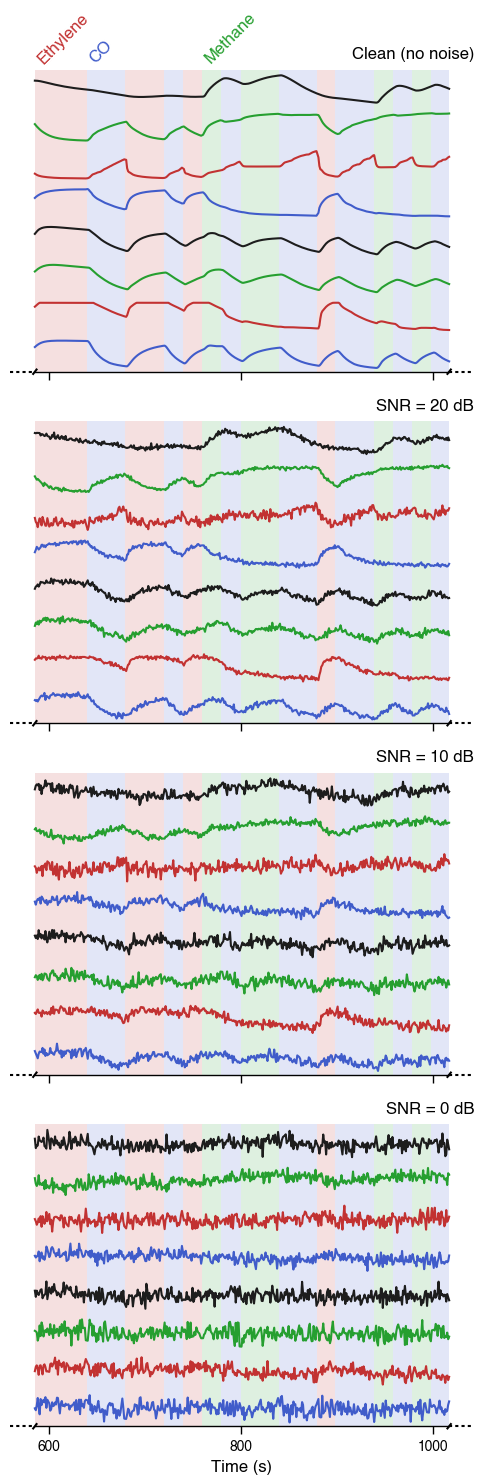

In [34]:
from datetime import datetime
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# ----------------------------
# Load your data
# ----------------------------
filename = '1_600_20'
# expects: times_sec (per-sample seconds), sequence_sec (change times for sequence)
# plus (in scope): sensor_data, responding_sens, sensor_id, sequence
_, _, times_sec, sequence_sec = load(filename, reduced=True)
# Rebase to seconds since the first value in sensor_data
t0 = float(times_sec[0])
t_secs0 = times_sec - t0

# ----------------------------
# Window selection (inclusive indices)
# ----------------------------
idx_start, idx_end = 570, 980
idx_start = max(0, int(idx_start))
idx_end = min(len(times_sec) - 1, int(idx_end))
if idx_end <= idx_start:
    raise ValueError("idx_end must be greater than idx_start.")
sl = slice(idx_start, idx_end + 1)
t_sub = t_secs0[sl]   # windowed time in seconds since start

# ----------------------------
# Trace placement constants
# ----------------------------
idxs = [i for i, v in enumerate(responding_sens) if v == 1]
names = [re.sub(r'^\s*UX\s*-\s*', '', sensor_id[i]) for i in idxs]

TARGET_HALF_HEIGHT = 0.9
TRACE_SCALE        = 0.8
AMP                = TRACE_SCALE * TARGET_HALF_HEIGHT  # ~0.72
EPS                = 1e-12
BASELINE_LEN       = 300

if len(idxs) > 0:
    bottom_of_lowest = -AMP
    top_of_highest   = 2 * (len(idxs) - 1) + AMP
else:
    bottom_of_lowest = 0.0
    top_of_highest   = 1.0

LABEL_HEADROOM = -0.2
y_label_data   = top_of_highest + 0.5
ymin_fixed     = bottom_of_lowest - 0.20
ymax_fixed     = y_label_data + LABEL_HEADROOM

# ----------------------------
# Background gas rectangles
# ----------------------------
max_len_blocks = 20
rect_alpha     = 0.15

gas_names = {1: "CO", 2: "Ethylene", 3: "Methane"}
def _gas_label(lab: int) -> str:
    return gas_names.get(int(lab), f"Gas {int(lab)}")

# per-sample gas labels over full recording
colour_full = np.zeros_like(times_sec, dtype=int)
for i in range(len(sequence_sec)):
    t_start = sequence_sec[i]
    t_end   = sequence_sec[i + 1] if i + 1 < len(sequence_sec) else np.inf
    mask = (times_sec >= t_start) & (times_sec < t_end)
    colour_full[mask] = int(sequence[i][1])  # adjust if your sequence structure differs

labels_local = colour_full[sl]
x_window     = t_sub

def _find_blocks(labels, max_len=20, ignore=0):
    labels = np.asarray(labels)
    n = len(labels)
    if n == 0: return []
    blocks, start, prev = [], 0, labels[0]
    for i in range(1, n + 1):
        cur = labels[i] if i < n else None
        if cur != prev:
            if prev != ignore:
                run_start, run_end, lab = start, i, int(prev)
                s = run_start
                while s < run_end:
                    e = min(s + max_len, run_end)
                    blocks.append((s, e, lab))  # [s,e)
                    s = e
            start, prev = i, cur
    return blocks

def _block_edges_from_indices(x, s, e):
    if s <= 0:
        L = x[0]
    else:
        L = 0.5 * (x[s - 1] + x[s])
    if e >= len(x):
        R = x[-1]
    else:
        R = 0.5 * (x[e - 1] + x[e])
    return L, R

blocks = _find_blocks(labels_local, max_len=max_len_blocks, ignore=0)

# ----------------------------
# Helper: assemble windowed traces (columns = sensors shown)
# ----------------------------
def get_windowed_traces_matrix():
    cols = []
    for i in idxs:
        # sensor_data is (N, 8); sensor_data.T[i] selects column i (length N)
        row = sensor_data.T[i]
        b_len = min(BASELINE_LEN, len(row))
        baseline = float(np.mean(row[:b_len]))
        signal = (row - baseline) / 65536.0
        s_sub = np.asarray(signal)[sl]
        cols.append(s_sub)
    if not cols:
        return np.zeros((len(t_sub), 0))
    return np.stack(cols, axis=1)  # shape: (len(t_sub), M)

S_clean = get_windowed_traces_matrix()  # (T, M)

# ----------------------------
# Noise adder for (N, M) with per-column SNR
# ----------------------------
def add_white_noise_cols(X, snr_db=None, snr_linear=None, seed=None, eps=1e-12):
    X = np.asarray(X, dtype=float)
    if X.ndim != 2:
        raise ValueError("X must be 2D, shape (N, M).")
    if (snr_db is None) == (snr_linear is None):
        raise ValueError("Provide exactly one of snr_db or snr_linear.")
    if snr_linear is None:
        snr_linear = 10.0 ** (snr_db / 10.0)
    sig_power = np.mean(X**2, axis=0, keepdims=True)  # (1, M)
    noise_power = sig_power / (snr_linear + eps)
    noise_std = np.sqrt(np.maximum(noise_power, 0.0))  # (1, M)
    rng = np.random.default_rng(seed)
    noise = rng.normal(0.0, 1.0, size=X.shape) * noise_std
    return X + noise

# --- x-axis slashes helper ---
from matplotlib.lines import Line2D
def decorate_x_axis_with_slashes(ax, x0, x1, ext_frac=0.06):
    Lx = x1 - x0
    ext = ext_frac * Lx
    ax.set_xlim(x0 - ext, x1 + ext)
    xax = ax.get_xaxis_transform()
    axis_color = ax.spines["bottom"].get_edgecolor()
    for x_pair in [(x0 - ext, x0), (x1, x1 + ext)]:
        ax.add_line(Line2D(
            x_pair, [0, 0], transform=xax,
            linestyle=(0, (1.5, 1.5)), linewidth=1.5,
            color=axis_color, solid_capstyle="butt",
            clip_on=False, zorder=3
        ))
    xmin, xmax = ax.get_xlim()
    span = xmax - xmin
    slash_w = 0.01 * span
    slash_h = 0.01
    for xc in (x0, x1):
        ax.add_line(Line2D(
            [xc - 0.5 * slash_w, xc + 0.5 * slash_w],
            [-slash_h, slash_h],
            transform=xax, linewidth=1.5,
            color=axis_color, solid_capstyle="butt",
            clip_on=False, zorder=4
        ))
    ax.spines["bottom"].set_bounds(x0, x1)

# ----------------------------
# Plotting helper for one panel
# ----------------------------
def plot_panel(ax, X_panel, title, show_gas_labels=True):
    # Background spans
    for s, e, lab in blocks:
        if lab == 0:
            continue
        L, R = _block_edges_from_indices(x_window, s, e)
        if R <= L:
            continue
        ax.axvspan(
            L, R, ymin=0.0, ymax=1.0,
            facecolor=cmap((int(lab) - 1) % cmap.N),
            alpha=rect_alpha, linewidth=0, zorder=0
        )

    # Traces (stacked)
    for k in range(X_panel.shape[1]):
        s_sub = X_panel[:, k]
        s_min, s_max = float(np.min(s_sub)), float(np.max(s_sub))
        s_mid = 0.5 * (s_max + s_min)
        p2p  = max(s_max - s_min, EPS)
        s_scaled = (s_sub - s_mid) * (TARGET_HALF_HEIGHT / (0.5 * p2p + EPS))
        ax.plot(t_sub, TRACE_SCALE * s_scaled + 2 * k, zorder=2)

    # Gas labels (only if requested)
    if show_gas_labels:
        seen_for_label = set()
        x_text_offset = -0.5
        for s, e, lab in blocks:
            if lab == 0 or lab in seen_for_label:
                continue
            L, R = _block_edges_from_indices(x_window, s, e)
            if R <= L:
                continue
            seen_for_label.add(lab)
            x_mid = 0.5 * (L + R)
            x_lbl = x_mid + x_text_offset * (R - L)
            ax.text(
                x_lbl, y_label_data, _gas_label(lab),
                transform=ax.transData, ha='left', va='bottom',
                rotation=45,
                color=cmap((int(lab) - 1) % cmap.N),
                clip_on=False, zorder=5
            )

    # Axes cosmetics
    ax.set_ylim(ymin_fixed, ymax_fixed)
    # ax.set_yticks([2 * k for k in range(len(idxs))])
    # ax.set_yticklabels(names if ax.is_first_col() else [])
    ax.set_yticks([])
    ax.set_xlabel("Time (s)" if ax.get_subplotspec().is_last_row() else "")

    # x-lims with small extension + slashes
    x0, x1 = t_secs0[idx_start], t_secs0[idx_end]
    Lx = x1 - x0
    ext = 0.06 * Lx
    ax.set_xlim(x0 - ext, x1 + ext)

    # Right-aligned title
    ax.set_title(title, pad=8, loc='right', fontsize=12)

    # styling
    ax.spines[["top", "right", "left"]].set_visible(False)
    ax.tick_params(left=False, labelleft=ax.get_subplotspec().is_first_col())

    # add slashes
    decorate_x_axis_with_slashes(ax, x0, x1, ext_frac=0.06)

# ----------------------------
# Build the 4×1 figure: clean + 3 noisy panels
# ----------------------------
fig, axs = plt.subplots(4, 1, figsize=(5, 15), sharex=True, sharey=True)
axs = np.atleast_1d(axs)

# Panel 0: clean (with gas labels)
plot_panel(axs[0], S_clean, "Clean (no noise)", show_gas_labels=True)

# Panels 1–3: noisy (no gas labels)
snr_list_db = [20, 10, 0]  # keep your current SNR list
for j, snr_db in enumerate(snr_list_db, start=1):
    S_noisy = add_white_noise_cols(S_clean, snr_db=snr_db, seed=42 + j)
    plot_panel(axs[j], S_noisy, f"SNR = {snr_db} dB", show_gas_labels=False)

# Global x ticks (optional)
axs[-1].set_xticks([600, 800, 1000])

plt.tight_layout()

# ----------------------------
# Save & show
# ----------------------------
plt.savefig('figs/sensor_signal_with_noise.png', dpi=300)
plt.savefig('figs/sensor_signal_with_noise.pdf', dpi=300)
plt.show()
